In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [6]:
# build the vocabulary

chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [16]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def buld_the_dataset(words):
  X,Y = [],[]

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buld_the_dataset(words[:n1])
Xdev, Ydev = buld_the_dataset(words[n1:n2])
Xte, Yte = buld_the_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [17]:
# MLP revisited

n_emb = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)   # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numner of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  emb = C[Xtr[ix]] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vector
  hpreact = embcat @ W1 + b1 # hidden layer preactivation
  h = torch.tanh(hpreact) # nonlinearity, hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 26.5404
  10000/ 200000: 2.8297
  20000/ 200000: 2.5702
  30000/ 200000: 2.2293
  40000/ 200000: 2.3720
  50000/ 200000: 2.7074
  60000/ 200000: 2.3786
  70000/ 200000: 2.3498
  80000/ 200000: 2.1334
  90000/ 200000: 2.0449
 100000/ 200000: 2.3394
 110000/ 200000: 2.3778
 120000/ 200000: 2.2828
 130000/ 200000: 2.4198
 140000/ 200000: 2.2789
 150000/ 200000: 2.2704
 160000/ 200000: 2.1293
 170000/ 200000: 2.1585
 180000/ 200000: 2.4126
 190000/ 200000: 2.0491


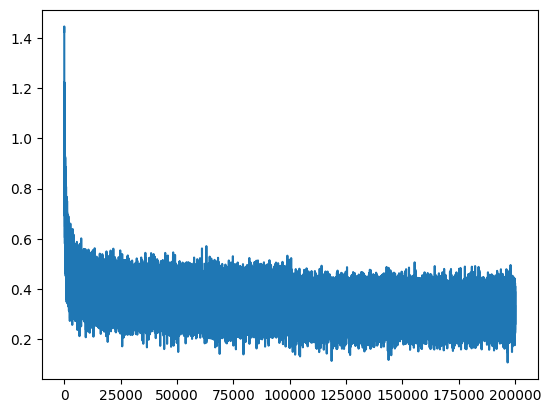

In [26]:
plt.plot(lossi)

In [27]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1201937198638916
val 2.162367582321167


In [29]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the window
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

mora.
mayanniellend.
ryah.
rethantendrae.
cadelynneliighlynne.
leigh.
van.
nar.
katykollya.
cayshabergahimiel.
kindreeller.
nopatrius.
kace.
ryyah.
fael.
yuma.
myskella.
hil.
salynn.
ung.
